# 2-layer FNN on Cifar

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [1]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools


%matplotlib inline

In [2]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0):

    valid_loss_str     = lines0[-5]
    valid_accuracy_str = lines0[-6]
    train_loss_str     = lines0[-8]
    train_accuracy_str = lines0[-9]
    run_time_str       = lines0[-10]

    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(line0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [53]:
results_dir = '../results/lrb_lenet_cifar_no_dropout'
       
depth = [2]
width = [200]
dim_   = [0,600,800,1000,1250,1500,2500,3500,4500,5500,6000,6500,7000,7250,7500,7750,8000,9000,10000,15000]

sr=0.9 # solved ratio


########## 1. filename list of diary ########################
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    for file in files:
        if file == 'diary':
            fname = os.path.join(subdir, file)
            diary_names.append(fname)
            
# print diary_names

########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nw, nd, nn= len(width), len(depth), len(dim)

acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
num_param_all = np.zeros((len(width), len(depth)))
acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.zeros((len(width), len(depth)))

mode = 1         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all

            
# 2.1.1 Read the results 
ll, ww, dim= depth[0], width[0], []
results_ = []
for f in diary_names:
    fname = f.split('/')[-2]
    d = int(fname.split('_')[-1])
    dim.append(d)
    # print str(d)+'_'+str(ll)+'_'+str(w)

    with open(f,'r') as ff:
        lines0 = ff.readlines()
        try:
            R = extract_num(lines0)
            R = np.array(R)

        except ValueError:
            error_files.append((w,ll,d))
            R = np.zeros(len(R))
            print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
            # break
            
    results_.append(R)
      
idx = np.argsort(np.array(dim)) 

                   
# 2.2 Assign the results, construct acc_solved_all and dim_solved_all           
id_w,id_ll = 0,0
results = []
for id_d in range(len(dim)):
    d = dim[id_d]
    i = idx[id_d]
    results.append(results_[i])
    
    
    if d==0:
        test_acc_bl = results_[i][1]        
        # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
    else:
        test_acc = r
        if test_acc>test_acc_bl*sr:
            acc_solved_all[id_w,id_ll]=test_acc
            dim_solved_all[id_w,id_ll]=d
            # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
            # print "\n"
            # break
            
results = np.array(results)            

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*sr
                                       

In [54]:
dim = np.sort(dim)
print results.shape
print dim

print "Baseline results"
print test_acc_bl

print "# Parmas"
print num_param_all

print "Cross-line results"
print acc_solved_all

print "Cross-line Dim"
print dim_solved_all

print "Dim %d results" % dim[-1]
print acc_test_all[:,:,-1]

(30, 5)
[    0    10    50   100   250   500   750  1000  1250  1500  1750  2000
  2500  3000  4000  5000 10000 15000 16000 17000 18000 19000 20000 21000
 25000 30000 35000 40000 45000 50000]
Baseline results
0.4857
# Parmas
[[ 0.]]
Cross-line results
[[ 0.]]
Cross-line Dim
[[ 0.]]
Dim 50000 results
[[ 0.]]


#### List the config of depth and width, which yields errors in training

In [45]:
E_width, E_depth, E_dim = [],[],[]
for item in error_files:
    E_width.append(item[0]) 
    E_depth.append(item[1])
    E_dim.append(item[2])

str_E_width = "".join(str(E_width)).replace(',', '')
str_E_depth = "".join(str(E_depth)).replace(',', '')
str_E_dim   = "".join(str(E_dim)).replace(',', '')

print "Error in the following configs: width, depth and dim"
print str_E_width
print str_E_depth
print str_E_dim

print "Shape of accuracy tensor: " + str(acc_test_all.shape)

Error in the following configs: width, depth and dim
[]
[]
[]
Shape of accuracy tensor: (1, 1, 19)


-------------------------

#### Check the accuracy of specific depth and width, along different dim

In [46]:
def check_cfg_results (depth, width, lines0): 
    for d in dim:
        # 1. read the results
        for f in diary_names:
            if '_'+str(d)+'_'+str(depth)+'_'+str(width)+'/' in f:
                # print "%d is in" % d + f
                diary_names_ordered.append(f)
                with open(f,'r') as ff:
                    lines0 = ff.readlines()
                    try:
                        # print lines0
                        param_num = parse_num_params(lines0)
                        R = extract_num(lines0)
                        print R[1]

                    except ValueError:
                        print "Error: Can not read"
                        break                                               

Reshape the tensor to 1D for plots

### Testing Accuracy wrt. Width, Depth and Dim

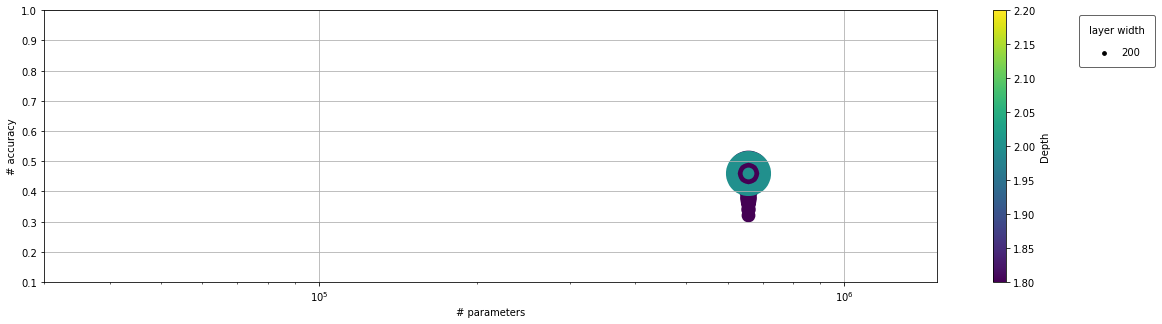

In [48]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, sr*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.1, 1.0)
ax.set_xlim(0.3E5, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

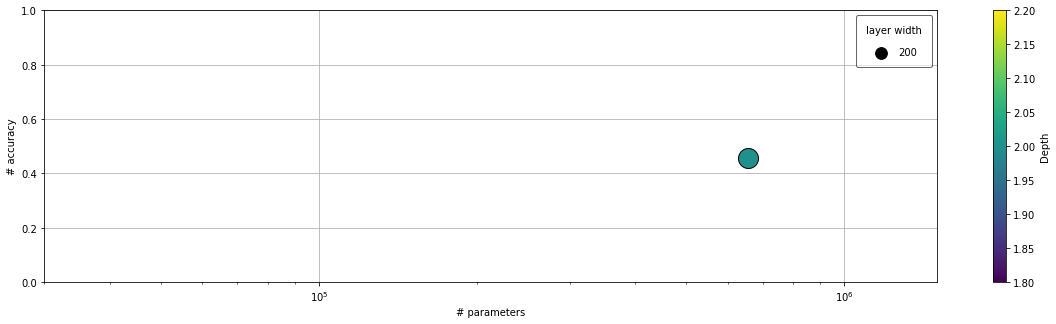

In [49]:
plt.figure(figsize=(20,5))


plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

## Performance comparison with Baseline

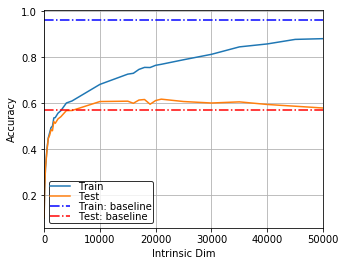

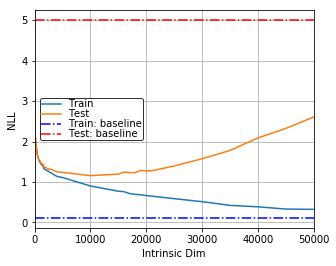

In [59]:
nn = len(dim)-1
fig, ax = subplots(figsize=(5,4))
ax.plot(dim[1:], results[1:,3], label="Train")
ax.plot(dim[1:], results[1:,1], label="Test")
ax.plot(dim[1:], results[0,3]*np.ones(nn),'b-.', label="Train: baseline")
ax.plot(dim[1:], results[0,1]*np.ones(nn),'r-.', label="Test: baseline")
ax.set_xlabel('Intrinsic Dim')
ax.set_ylabel('Accuracy')
plt.grid()
ax.set_xlim([0,50000])
# ax.set_ylim([0.05,0.8])
plt.legend(labelspacing=0.0, borderpad=0.1,edgecolor="k", facecolor="w")
fig.savefig("figs/lenet_cifar_l2_train_testacc.pdf", bbox_inches='tight')

fig, ax = subplots(figsize=(5,4))
ax.plot(dim[1:], results[1:,2], label="Train")
ax.plot(dim[1:], results[1:,0], label="Test")
ax.plot(dim[1:], results[0,2]*np.ones(nn),'b-.', label="Train: baseline")
ax.plot(dim[1:], results[0,0]*np.ones(nn),'r-.', label="Test: baseline")
ax.set_xlabel('Intrinsic Dim')
ax.set_ylabel('NLL')
plt.grid()
ax.set_xlim([0,50000])
# ax.set_ylim([0.75,2.5])
plt.legend(labelspacing=0.0, borderpad=0.1,edgecolor="k", facecolor="w")
fig.savefig("figs/lenet_cifar_l2_train_test_nll.pdf", bbox_inches='tight')